In [47]:
import sys
sys.path.append('..')

from utils import *
from data_utils import *
from metrics import *
from plots import *

In [48]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Transfer Learning from the first 5 to the second 5 of MNIST. Default initialization with freezing.

In [49]:
batch_size = 128
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
depth = 20

dataset = TransferLearningMNIST(batch_size)
dataset_wrapped = TransferLearningMNISTWrapper(dataset, 'pretrain')
params = dict(device=device,
                width=100, lr=0.01, num_train=4,
                sb=0.05, depth= depth, sw=1.7346938775510203, early_stop_patience = 2, activation_function='tanh')

model = generate_fc_dnn(dataset.input_dim, dataset.output_dim,
                params, gaussian_init = True).to(device)

In [50]:
#print model summary
print(model)

Sequential(
  (linear0): Linear(in_features=784, out_features=100, bias=True)
  (activation0): Tanh()
  (linear1): Linear(in_features=100, out_features=100, bias=True)
  (activation1): Tanh()
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (activation2): Tanh()
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (activation3): Tanh()
  (linear4): Linear(in_features=100, out_features=100, bias=True)
  (activation4): Tanh()
  (linear5): Linear(in_features=100, out_features=100, bias=True)
  (activation5): Tanh()
  (linear6): Linear(in_features=100, out_features=100, bias=True)
  (activation6): Tanh()
  (linear7): Linear(in_features=100, out_features=100, bias=True)
  (activation7): Tanh()
  (linear8): Linear(in_features=100, out_features=100, bias=True)
  (activation8): Tanh()
  (linear9): Linear(in_features=100, out_features=100, bias=True)
  (activation9): Tanh()
  (linear10): Linear(in_features=100, out_features=100, bias=True)
  (activation10): Tan

In [51]:
results, variances = compute_layer_variances_dense(model, dataset_wrapped.train_loader, device = 'cpu',cnn=False)
for layer_name, stats in results.items():
    print(f"Layer {layer_name} - Variance: {stats['variance']}, Variance of Variance: {stats['variance_of_variance']}")

Layer linear0 - Variance: 2.7823567390441895, Variance of Variance: 0.3098544776439667
Layer activation0 - Variance: 0.5767860412597656, Variance of Variance: 0.03331584110856056
Layer linear1 - Variance: 1.0494002103805542, Variance of Variance: 0.11757747828960419
Layer activation1 - Variance: 0.4050511121749878, Variance of Variance: 0.02667045406997204
Layer linear2 - Variance: 0.7299839854240417, Variance of Variance: 0.09584570676088333
Layer activation2 - Variance: 0.33893144130706787, Variance of Variance: 0.023153647780418396
Layer linear3 - Variance: 0.5635475516319275, Variance of Variance: 0.07326891273260117
Layer activation3 - Variance: 0.29077988862991333, Variance of Variance: 0.023492874577641487
Layer linear4 - Variance: 0.5232783555984497, Variance of Variance: 0.07999223470687866
Layer activation4 - Variance: 0.28698405623435974, Variance of Variance: 0.026920603588223457
Layer linear5 - Variance: 0.6062099933624268, Variance of Variance: 0.08405639976263046
Layer a

In [52]:
# same code gives the same result - the difference is the dataloader still shuffles the data randomly, 
# but now it's the variance over the whole dataset
results, variances = compute_layer_variances_dense(model, dataset_wrapped.train_loader, device = 'cpu',cnn=False)
for layer_name, stats in results.items():
    print(f"Layer {layer_name} - Variance: {stats['variance']}, Variance of Variance: {stats['variance_of_variance']}")

Layer linear0 - Variance: 2.7823567390441895, Variance of Variance: 0.30985450744628906
Layer activation0 - Variance: 0.5767860412597656, Variance of Variance: 0.03331584483385086
Layer linear1 - Variance: 1.0494002103805542, Variance of Variance: 0.11757748574018478
Layer activation1 - Variance: 0.4050510823726654, Variance of Variance: 0.02667045406997204
Layer linear2 - Variance: 0.7299840450286865, Variance of Variance: 0.09584570676088333
Layer activation2 - Variance: 0.33893144130706787, Variance of Variance: 0.023153645917773247
Layer linear3 - Variance: 0.5635475516319275, Variance of Variance: 0.07326890528202057
Layer activation3 - Variance: 0.29077988862991333, Variance of Variance: 0.023492876440286636
Layer linear4 - Variance: 0.5232783555984497, Variance of Variance: 0.07999223470687866
Layer activation4 - Variance: 0.28698405623435974, Variance of Variance: 0.026920603588223457
Layer linear5 - Variance: 0.606209933757782, Variance of Variance: 0.08405639976263046
Layer a

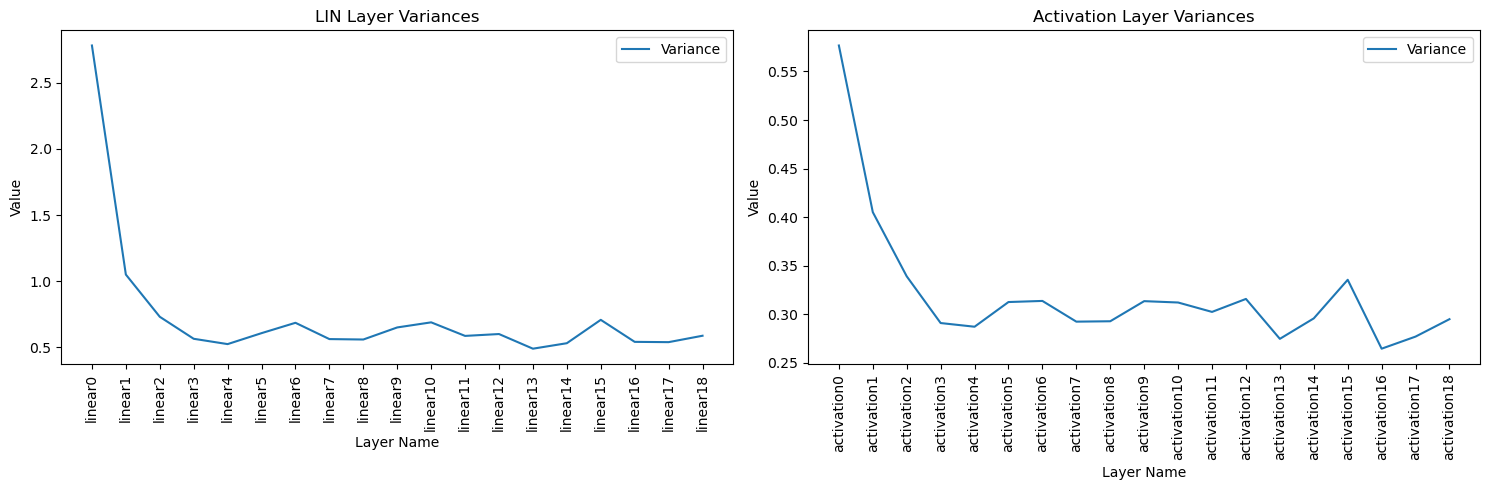

In [53]:
plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True)

# To Test the effect of layer width on activation variances: -Normalization in progress

In [54]:
def generate_fc_dnn(input_dim, output_dim, params, activation_function=nn.Tanh, gaussian_init=True):
    depth, width = params['depth'], params['width']
    widths = [300, 300, 300, 300, 30, 300, 300, 300, 300, 300]
    def gen_linear_layer_dim(layer_index):
        return {
            0: (input_dim, widths[0]),
            depth - 1: (widths[-1], output_dim),
        }.get(layer_index, (widths[layer_index-1], widths[layer_index]))
    
    model = nn.Sequential()
    
    for i in range(depth):
        linear_layer = nn.Linear(*gen_linear_layer_dim(i))
        activation_layer = nn.LogSoftmax(dim=1) if (depth - 1 == i) else activation_function()
        
        # Give descriptive names to layers
        setattr(model, f"linear{i}", linear_layer)
        setattr(model, f"activation{i}", activation_layer)
        
    if gaussian_init:
        model.apply(lambda m: init_weights(m, params['sw'], params['sb']))
    return model

In [55]:
batch_size = 128
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
depth = 10

dataset = TransferLearningMNIST(batch_size)
dataset_wrapped = TransferLearningMNISTWrapper(dataset, 'pretrain')
params = dict(device=device,
                width=300, lr=0.01, num_train=4,
                sb=0.05, depth= depth, sw=1.7346938775510203, early_stop_patience = 2, activation_function='tanh')

model = generate_fc_dnn(dataset.input_dim, dataset.output_dim,
                params, gaussian_init = True).to(device)

In [56]:
print(model)

Sequential(
  (linear0): Linear(in_features=784, out_features=300, bias=True)
  (activation0): Tanh()
  (linear1): Linear(in_features=300, out_features=300, bias=True)
  (activation1): Tanh()
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (activation2): Tanh()
  (linear3): Linear(in_features=300, out_features=300, bias=True)
  (activation3): Tanh()
  (linear4): Linear(in_features=300, out_features=30, bias=True)
  (activation4): Tanh()
  (linear5): Linear(in_features=30, out_features=300, bias=True)
  (activation5): Tanh()
  (linear6): Linear(in_features=300, out_features=300, bias=True)
  (activation6): Tanh()
  (linear7): Linear(in_features=300, out_features=300, bias=True)
  (activation7): Tanh()
  (linear8): Linear(in_features=300, out_features=300, bias=True)
  (activation8): Tanh()
  (linear9): Linear(in_features=300, out_features=10, bias=True)
  (activation9): LogSoftmax(dim=1)
)


In [57]:
np.array([1,2,3]) / 2

array([0.5, 1. , 1.5])

In [58]:
def compute_layer_variances_dense(model, test_loader, device='cpu', cnn=True, normalize_by=lambda x:1.):
    activations = {}

    for name, layer in model.named_modules():
        if name:  # this ensures we skip the top-level module (the entire model) which has an empty name
            activations[name] = []

    def create_hook(name):
        def hook(module, input, output):
            activations[name].extend(list(torch.var(output, dim=1).numpy() / normalize_by(module.weight)))
        return hook


    for name, layer in model.named_modules():
        if name:  # this ensures we skip the top-level module (the entire model) which has an empty name
            activations[name] = []
            layer.register_forward_hook(create_hook(name))

    # Run inference on the test set
    i = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cnn:
                data = data.to(device)
            else:
                data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            outputs = model(data)
            i += 1
            
    # Calculate variance for each layer's activations
    result = {}
    for layer_name, variances in activations.items():
        result[layer_name] = {
            'variance': np.mean(variances),
            'variance_of_variance': np.std(variances)
        }
        
    return result, activations

# A Weird way to Check if the SEED is still set:

In [59]:
# to check if anything messed up with the seed run: check_seed(x) : all should be True
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

pretrain_val_set = dataset.pretrain_val_loader.dataset
a1, b1 = torch.utils.data.random_split(
                pretrain_val_set, [10, len(pretrain_val_set) - 10])
x = a1[0][0].numpy()[0][15]

def check_seed(x):
    a1, b1 = torch.utils.data.random_split(
                pretrain_val_set, [10, len(pretrain_val_set) - 10], generator=torch.Generator().manual_seed(42))
    return x == a1[0][0].numpy()[0][15]

check_seed(x)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

# REST

In [60]:
pretrain_train_acc, pretrain_test_acc, pre_trained_model, pretraining_checkpoints = compute_training_acc_epochs(model, dataset_wrapped, params, debug=True, save_checkpoints=False)

Epoch: 0 	Training Accuracy: 93.87%
Validation Accuracy: 93.27%
Epoch: 1 	Training Accuracy: 57.52%
Validation Accuracy: 58.29%
val_acc: 0.5828702190258255, max_val_acc: 0.9326577312847336, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 97.64%
Validation Accuracy: 96.70%
Epoch: 3 	Training Accuracy: 95.38%
Validation Accuracy: 94.64%
val_acc: 0.9463877084014384, max_val_acc: 0.9669826740764956, no_improve_epochs: 1


In [61]:
# Save model state dictionary
# torch.save(pre_trained_model.state_dict(), "pretrained_MNIST_model_50-50.pth")
# torch.save(pretraining_checkpoints, 'pretrained_MNIST_model_50-50_checkpoints.pth')

#### finetuning expermient

In [62]:
dataset_wrapped.update_phase('finetune')

In [63]:
from tqdm import tqdm

num_experiments = 5
experiments = []

for i in tqdm(range(num_experiments)):
    print('experiment number: ', i)
    cut_models = []
    for cut in range(depth):
        temp = {}
        temp['cut_model'] = cut_model(pre_trained_model, cut_point = cut, freeze = False)
        finetuned_acc, finetuned_test_acc, finetuned_model ,checkpoints_temp = compute_training_acc_epochs(temp['cut_model'], dataset_wrapped, params, debug=True)
        temp['finetuned_acc'] = finetuned_acc
        temp['finetuned_test_acc'] = finetuned_test_acc
        temp['finetuned_model'] = finetuned_model
        temp['checkpoints'] = checkpoints_temp
        cut_models.append(temp)  
    experiments.append(cut_models)

  0%|          | 0/5 [00:00<?, ?it/s]

experiment number:  0
Epoch: 0 	Training Accuracy: 92.54%
Validation Accuracy: 91.67%
Epoch: 1 	Training Accuracy: 94.91%
Validation Accuracy: 93.95%
Epoch: 2 	Training Accuracy: 96.30%
Validation Accuracy: 95.37%
Epoch: 3 	Training Accuracy: 96.60%
Validation Accuracy: 95.92%
Epoch: 0 	Training Accuracy: 93.09%
Validation Accuracy: 92.24%
Epoch: 1 	Training Accuracy: 94.70%
Validation Accuracy: 94.01%
Epoch: 2 	Training Accuracy: 94.57%
Validation Accuracy: 93.33%
val_acc: 0.9333333333333333, max_val_acc: 0.9401360544217687, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 97.58%
Validation Accuracy: 96.60%
Epoch: 0 	Training Accuracy: 93.07%
Validation Accuracy: 92.28%
Epoch: 1 	Training Accuracy: 95.63%
Validation Accuracy: 95.03%
Epoch: 2 	Training Accuracy: 95.31%
Validation Accuracy: 94.25%
val_acc: 0.9425170068027211, max_val_acc: 0.9503401360544218, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 96.38%
Validation Accuracy: 95.78%
Epoch: 0 	Training Accuracy: 89.23%
Validati

 20%|██        | 1/5 [02:24<09:37, 144.42s/it]

experiment number:  1
Epoch: 0 	Training Accuracy: 93.12%
Validation Accuracy: 92.93%
Epoch: 1 	Training Accuracy: 95.54%
Validation Accuracy: 94.86%
Epoch: 2 	Training Accuracy: 95.36%
Validation Accuracy: 94.63%
val_acc: 0.9462585034013605, max_val_acc: 0.9486394557823129, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 97.18%
Validation Accuracy: 95.71%
Epoch: 0 	Training Accuracy: 93.63%
Validation Accuracy: 93.44%
Epoch: 1 	Training Accuracy: 94.04%
Validation Accuracy: 92.82%
val_acc: 0.9282312925170068, max_val_acc: 0.9343537414965987, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 94.13%
Validation Accuracy: 93.54%
Epoch: 3 	Training Accuracy: 96.89%
Validation Accuracy: 95.99%
Epoch: 0 	Training Accuracy: 91.68%
Validation Accuracy: 91.22%
Epoch: 1 	Training Accuracy: 95.37%
Validation Accuracy: 94.86%
Epoch: 2 	Training Accuracy: 96.57%
Validation Accuracy: 95.88%
Epoch: 3 	Training Accuracy: 96.49%
Validation Accuracy: 95.82%
val_acc: 0.9581632653061225, max_val_acc: 0.

 40%|████      | 2/5 [04:48<07:13, 144.45s/it]

experiment number:  2
Epoch: 0 	Training Accuracy: 92.28%
Validation Accuracy: 91.60%
Epoch: 1 	Training Accuracy: 94.37%
Validation Accuracy: 93.20%
Epoch: 2 	Training Accuracy: 96.14%
Validation Accuracy: 95.34%
Epoch: 3 	Training Accuracy: 97.39%
Validation Accuracy: 96.50%
Epoch: 0 	Training Accuracy: 90.02%
Validation Accuracy: 89.18%
Epoch: 1 	Training Accuracy: 93.86%
Validation Accuracy: 93.16%
Epoch: 2 	Training Accuracy: 96.89%
Validation Accuracy: 95.85%
Epoch: 3 	Training Accuracy: 97.22%
Validation Accuracy: 96.09%
Epoch: 0 	Training Accuracy: 93.89%
Validation Accuracy: 93.33%
Epoch: 1 	Training Accuracy: 95.68%
Validation Accuracy: 94.76%
Epoch: 2 	Training Accuracy: 96.27%
Validation Accuracy: 95.48%
Epoch: 3 	Training Accuracy: 96.57%
Validation Accuracy: 95.24%
val_acc: 0.9523809523809523, max_val_acc: 0.9547619047619048, no_improve_epochs: 1
Epoch: 0 	Training Accuracy: 93.30%
Validation Accuracy: 92.65%
Epoch: 1 	Training Accuracy: 95.77%
Validation Accuracy: 94.83%

 60%|██████    | 3/5 [07:14<04:49, 145.00s/it]

experiment number:  3
Epoch: 0 	Training Accuracy: 93.63%
Validation Accuracy: 92.99%
Epoch: 1 	Training Accuracy: 94.97%
Validation Accuracy: 93.71%
Epoch: 2 	Training Accuracy: 96.54%
Validation Accuracy: 95.68%
Epoch: 3 	Training Accuracy: 96.60%
Validation Accuracy: 95.48%
val_acc: 0.9547619047619048, max_val_acc: 0.9568027210884353, no_improve_epochs: 1
Epoch: 0 	Training Accuracy: 93.74%
Validation Accuracy: 92.79%
Epoch: 1 	Training Accuracy: 94.92%
Validation Accuracy: 93.50%
Epoch: 2 	Training Accuracy: 96.60%
Validation Accuracy: 95.78%
Epoch: 3 	Training Accuracy: 97.61%
Validation Accuracy: 96.46%
Epoch: 0 	Training Accuracy: 93.69%
Validation Accuracy: 93.23%
Epoch: 1 	Training Accuracy: 95.90%
Validation Accuracy: 95.34%
Epoch: 2 	Training Accuracy: 95.65%
Validation Accuracy: 94.93%
val_acc: 0.9493197278911565, max_val_acc: 0.9534013605442176, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 97.27%
Validation Accuracy: 96.33%
Epoch: 0 	Training Accuracy: 90.00%
Validati

 80%|████████  | 4/5 [09:37<02:24, 144.10s/it]

experiment number:  4
Epoch: 0 	Training Accuracy: 93.90%
Validation Accuracy: 93.03%
Epoch: 1 	Training Accuracy: 95.38%
Validation Accuracy: 94.97%
Epoch: 2 	Training Accuracy: 96.71%
Validation Accuracy: 95.95%
Epoch: 3 	Training Accuracy: 95.40%
Validation Accuracy: 94.35%
val_acc: 0.9435374149659864, max_val_acc: 0.9595238095238096, no_improve_epochs: 1
Epoch: 0 	Training Accuracy: 89.65%
Validation Accuracy: 89.39%
Epoch: 1 	Training Accuracy: 95.67%
Validation Accuracy: 94.69%
Epoch: 2 	Training Accuracy: 96.17%
Validation Accuracy: 95.24%
Epoch: 3 	Training Accuracy: 96.60%
Validation Accuracy: 95.54%
Epoch: 0 	Training Accuracy: 89.43%
Validation Accuracy: 89.46%
Epoch: 1 	Training Accuracy: 95.21%
Validation Accuracy: 94.29%
Epoch: 2 	Training Accuracy: 92.61%
Validation Accuracy: 91.67%
val_acc: 0.9166666666666666, max_val_acc: 0.9428571428571428, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 97.24%
Validation Accuracy: 95.99%
Epoch: 0 	Training Accuracy: 92.72%
Validati

100%|██████████| 5/5 [11:59<00:00, 143.90s/it]


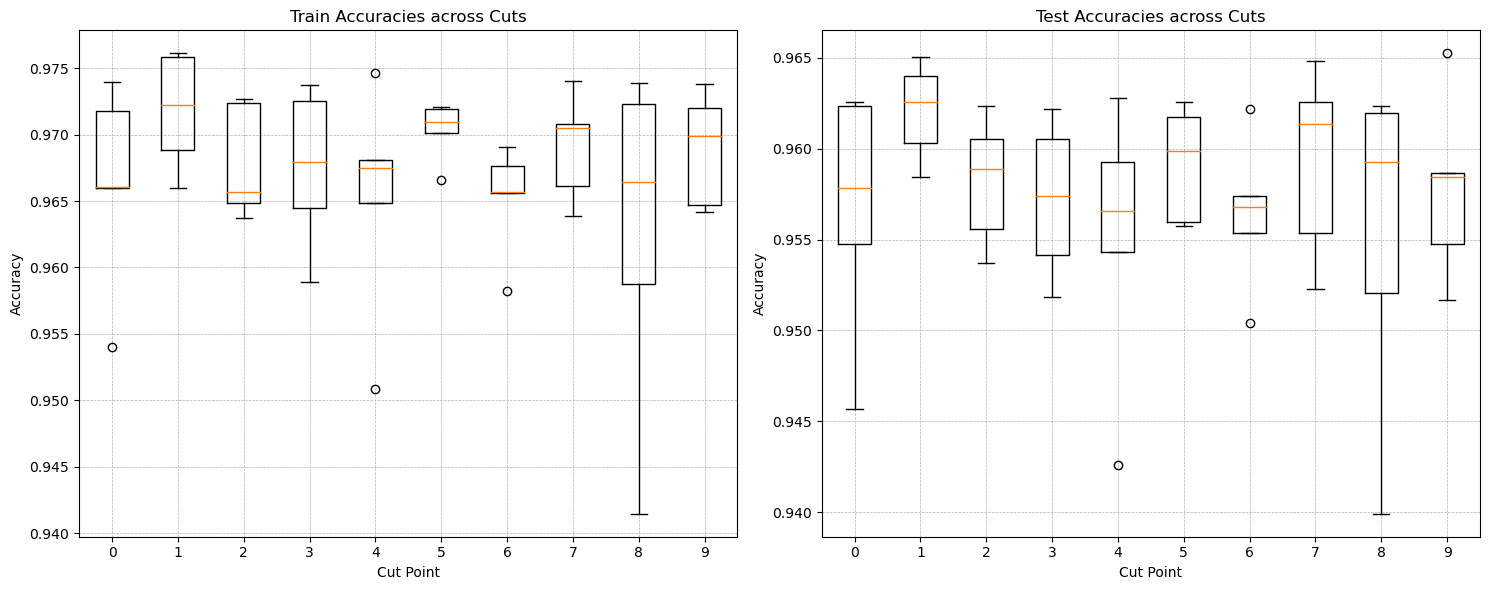

In [64]:
import matplotlib.pyplot as plt

# Initialize lists to store all accuracies for each cut point
train_accuracies = [[] for _ in range(depth)]
test_accuracies = [[] for _ in range(depth)]

# Populate the lists with accuracy values
for cut_models in experiments:
    for cut, model_data in enumerate(cut_models):
        train_accuracies[cut].append(model_data['finetuned_acc'])
        test_accuracies[cut].append(model_data['finetuned_test_acc'])

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot training accuracies
axs[0].boxplot(train_accuracies)
axs[0].set_title('Train Accuracies across Cuts')
axs[0].set_xlabel('Cut Point')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(range(1, depth + 1))
axs[0].set_xticklabels(range(depth))
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot test accuracies
axs[1].boxplot(test_accuracies)
axs[1].set_title('Test Accuracies across Cuts')
axs[1].set_xlabel('Cut Point')
axs[1].set_ylabel('Accuracy')
axs[1].set_xticks(range(1, depth + 1))
axs[1].set_xticklabels(range(depth))
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()

----